### Import

In [1]:
import os
import pandas as pd
import numpy as np
import qlib
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data import D
from qlib.data.filter import NameDFilter
from qlib.constant import REG_CN
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import ZScoreNorm, Fillna
from qlib.data.dataset import DatasetH, TSDatasetH

from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

from lstm import *
from mylightgbm import *

### Generate dataset

In [2]:
qlib.init(provider_uri='~/.qlib/qlib_data/cn_data')

[1448:MainThread](2022-07-01 18:03:26,052) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[1448:MainThread](2022-07-01 18:03:26,062) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[1448:MainThread](2022-07-01 18:03:26,065) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/.qlib/qlib_data/cn_data')}


In [3]:
# nameDFilter = NameDFilter(name_rule_re='SH000300')
# instruments = D.instruments(market='csi300', filter_pipe=[nameDFilter])
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money']
# data = D.features(instruments, fields, start_time='2008-01-01', end_time='2020-08-01', freq='day')
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money']])
df = qdl.load(instruments = ['SH000300'], start_time='2008-01-01', end_time='2020-08-01')

#### benefit

In [9]:
df1 = df.copy()
# df1['target'] = df1['close'].diff()
# df1['target'] = df1['target'] * 200
# df1
def compute_benefit(df):
    df['benefit'] = np.nan
    atr_list = [0]
    for i in range(df.benefit.size):
        # benefit
        if i < 30:
            df['benefit'].iloc[i] = 0
        else:
            df['benefit'].iloc[i] = df['close'].iloc[i] - df['close'].iloc[i - 30]

compute_benefit(df1)
df1

c:\Users\v-junmzhang\Anaconda3\envs\qlib\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 SH000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 SH000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 SH000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 SH000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 SH000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 SH000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 SH000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 SH000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 SH000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 SH000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money   benefit  
datetime   instrument                                                          
2008-01-02 SH000300    0.001018  5385.100098  0.008773  100618072.0  0.000000  
2008-01-03 SH000300    0.001018  5422.029785  0.006858  138364608.0  0.000000  
2008-01-04 SH000300    0.001018  5483.649902  0.011365  120947744.0  0.000000  
2008-01-07 SH000300    0.001018  5556.589844  0.013301  125346768.0  0.000000  
2008-01-08 SH000300    0.001018  5528.049805 -0.005136  150567008.0  0.000000  
...                         ...          ...       ...          ...       ...  
2020-07-27 SH000300    0.001018  4528.450195  0.005074  307179936.0  0.541896  
2020-07-28 SH000300    0.001018  4568.259766  0.008791  297963744.0  0.575077  
2020-07-29 SH000300    0.001018  4679.009766  0.024243  356569216.0  0.736699  
2020-07-30 SH000300    0.001018  4656.149902 -0.004886  329683104.0  0.652815  
2020-07-31 SH000300    0.001018  4695.049805  0.008355  357267904.0  0.689323  

[3061 rows x 10 columns]

In [10]:
print(df1.benefit.max())
print(df1.benefit.min())

1.2405500411987305
-1.5627756118774414


In [11]:
df1.to_csv('dataset/dataset_benefit3/SH000300.csv')

In [12]:
!python ../scripts/dump_bin.py dump_all --csv_path dataset/dataset_benefit3/SH000300.csv --date_field_name datetime --qlib_dir dataset/dataset_benefit3_bin --exclude_fields instrument

2022-07-01 18:05:39.182 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:04<00:00,  4.44s/it]
2022-07-01 18:05:43.629 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-07-01 18:05:43.629 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-07-01 18:05:43.652 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-07-01 18:05:43.653 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-07-01 18:05:43.653 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-07-01 18:05:43.655 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:04<00:00,  4.55s/it]
2022-07-01 18:05:48.206 | INFO     | __main__:_dump_features:312 - end of features dump.



#### risk

In [13]:
df2 = df.copy()

In [16]:
def compute_risk(df):
    df['risk'] = np.nan
    atr_list = [0]
    for i in range(df.risk.size):
        # risk
        if len(atr_list) == 30:
            atr_list.pop(0)
        if i > 0:
            atr_list.append(np.max(np.abs([df['high'].iloc[i] - df['low'].iloc[i], df['high'].iloc[i] - df['close'].iloc[i - 1], df['low'].iloc[i] - df['close'].iloc[i - 1]])))
        df['risk'].iloc[i] = np.mean(atr_list)

In [17]:
compute_risk(df2)
df2

c:\Users\v-junmzhang\Anaconda3\envs\qlib\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 SH000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 SH000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 SH000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 SH000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 SH000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 SH000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 SH000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 SH000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 SH000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 SH000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money      risk  
datetime   instrument                                                          
2008-01-02 SH000300    0.001018  5385.100098  0.008773  100618072.0  0.000000  
2008-01-03 SH000300    0.001018  5422.029785  0.006858  138364608.0  0.054294  
2008-01-04 SH000300    0.001018  5483.649902  0.011365  120947744.0  0.062329  
2008-01-07 SH000300    0.001018  5556.589844  0.013301  125346768.0  0.075657  
2008-01-08 SH000300    0.001018  5528.049805 -0.005136  150567008.0  0.090113  
...                         ...          ...       ...          ...       ...  
2020-07-27 SH000300    0.001018  4528.450195  0.005074  307179936.0  0.103269  
2020-07-28 SH000300    0.001018  4568.259766  0.008791  297963744.0  0.102523  
2020-07-29 SH000300    0.001018  4679.009766  0.024243  356569216.0  0.105221  
2020-07-30 SH000300    0.001018  4656.149902 -0.004886  329683104.0  0.105061  
2020-07-31 SH000300    0.001018  4695.049805  0.008355  357267904.0  0.108228  

[3061 rows x 10 columns]

In [19]:
print(df2.risk.max())
print(df2.risk.min())

0.2654734253883362
0.0


In [20]:
df2.to_csv('dataset/dataset_risk3/SH000300.csv')

In [21]:
!python ../scripts/dump_bin.py dump_all --csv_path dataset/dataset_risk3/SH000300.csv --date_field_name datetime --qlib_dir dataset/dataset_risk3_bin --exclude_fields instrument

2022-07-01 18:10:58.724 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:04<00:00,  4.50s/it]
2022-07-01 18:11:03.226 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-07-01 18:11:03.226 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-07-01 18:11:03.253 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-07-01 18:11:03.253 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-07-01 18:11:03.255 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-07-01 18:11:03.255 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:04<00:00,  4.76s/it]
2022-07-01 18:11:08.019 | INFO     | __main__:_dump_features:312 - end of features dump.



### LightGBM

#### benefit

In [2]:
provider_uri = "./dataset/dataset_benefit3_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)

[30236:MainThread](2022-07-01 18:38:36,044) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[30236:MainThread](2022-07-01 18:38:36,052) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[30236:MainThread](2022-07-01 18:38:36,054) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_benefit3_bin')}


In [3]:
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0        NaN  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   7.515335  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  12.539768  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  14.843464  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  -5.807972  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   4.652119  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   8.101368  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  22.537899  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0  -4.652023  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   7.916260  

[3061 rows x 10 columns]

In [4]:
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)

[30236:MainThread](2022-07-01 18:38:47,908) INFO - qlib.timer - [log.py:113] - Time cost: 0.015s | Loading data Done
[30236:MainThread](2022-07-01 18:38:47,911) INFO - qlib.timer - [log.py:113] - Time cost: 0.001s | Fillna Done
[30236:MainThread](2022-07-01 18:38:47,912) INFO - qlib.timer - [log.py:113] - Time cost: 0.003s | fit & process data Done
[30236:MainThread](2022-07-01 18:38:47,914) INFO - qlib.timer - [log.py:113] - Time cost: 0.021s | Init data Done


In [5]:
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

In [4]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

risk_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [81]:
lgb_train, lgb_eval, lgb_valid = get_dataset(x_train, y_train, x_test, y_test, x_valid, y_valid)

In [82]:
lgb_train.construct()
lgb_train.get_data()

LightGBMError: Cannot call `get_data` after freed raw data, set free_raw_data=False when construct Dataset to avoid this.

In [8]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1', 'auc', 'binary'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "max_depth": 20,
}

In [9]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5,
                valid_sets=lgb_valid,
                callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[5]	valid_0's l2: 54.418	valid_0's auc: 0.674978	valid_0's l1: 5.30399	valid_0's binary_logloss: 8.09187


In [10]:
gbm_benefit = gbm

In [22]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 11.374115817999204


(-100.0, 100.0)

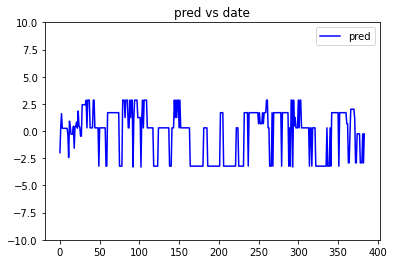

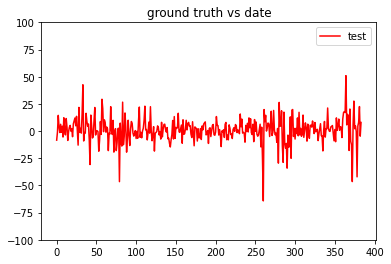

In [23]:
plt.plot(range(len(y_pred.tolist())), y_pred.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date")
plt.ylim([-10, 10])
plt.figure()
plt.plot(range(len(y_pred.tolist())), y_test, 'r', label='test')
plt.legend()
plt.title("ground truth vs date")
plt.ylim([-100, 100])

In [24]:
y_pred_benefit = y_pred

#### Train model - risk

In [11]:
provider_uri = "./dataset/dataset_risk3_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)

[30236:MainThread](2022-07-01 18:39:13,630) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[30236:MainThread](2022-07-01 18:39:13,637) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[30236:MainThread](2022-07-01 18:39:13,639) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_risk3_bin')}


In [12]:
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0        NaN  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0  21.717739  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  15.679836  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  23.128033  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  29.587173  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0  15.401077  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0  12.576389  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  26.803303  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0  11.164093  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0  24.389744  

[3061 rows x 10 columns]

In [13]:
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)

[30236:MainThread](2022-07-01 18:39:19,455) INFO - qlib.timer - [log.py:113] - Time cost: 0.010s | Loading data Done
[30236:MainThread](2022-07-01 18:39:19,457) INFO - qlib.timer - [log.py:113] - Time cost: 0.000s | Fillna Done
[30236:MainThread](2022-07-01 18:39:19,458) INFO - qlib.timer - [log.py:113] - Time cost: 0.002s | fit & process data Done
[30236:MainThread](2022-07-01 18:39:19,460) INFO - qlib.timer - [log.py:113] - Time cost: 0.015s | Init data Done


In [14]:
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

In [15]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

risk_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [16]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [17]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1', 'auc', 'binary'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "max_depth": 20,
}

In [18]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_valid,
                callbacks=[lgb.early_stopping(stopping_rounds=20)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000323 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's l2: 49.1917	valid_0's auc: 1	valid_0's l1: 5.99157	valid_0's binary_logloss: -2.64744


In [19]:
gbm_risk = gbm

In [33]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 8.466598118079032


(0.0, 100.0)

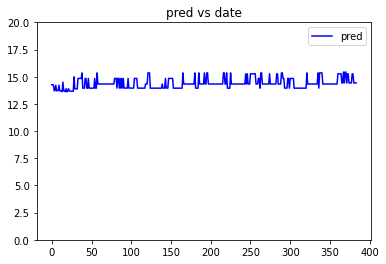

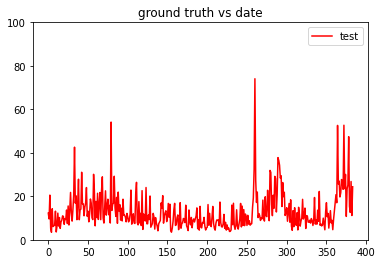

In [34]:
plt.plot(range(len(y_pred.tolist())), y_pred.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date")
plt.ylim([0,20])
plt.figure()
plt.plot(range(len(y_pred.tolist())), y_test.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date")
plt.ylim([0, 100])

In [35]:
y_pred_risk = y_pred

#### draw graph

In [36]:
x_train_benefit, y_train_benefit, x_test_benefit, y_test_benefit, x_valid_benefit, y_valid_benefit = benefit_datasets
x_train_risk, y_train_risk, x_test_risk, y_test_risk, x_valid_risk, y_valid_risk = risk_datasets

(-100.0, 100.0)

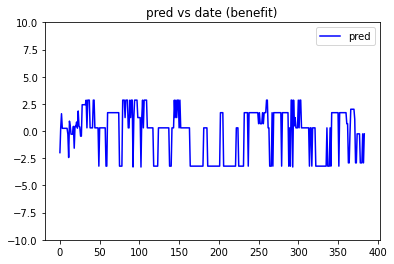

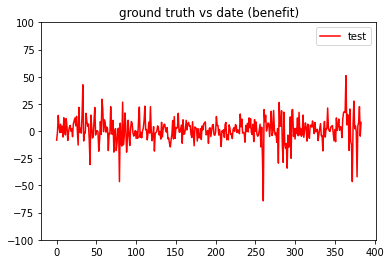

In [37]:
plt.plot(range(len(y_pred_benefit.tolist())), y_pred_benefit.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (benefit)")
plt.ylim([-10, 10])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (benefit)")
plt.ylim([-100, 100])

(0.0, 100.0)

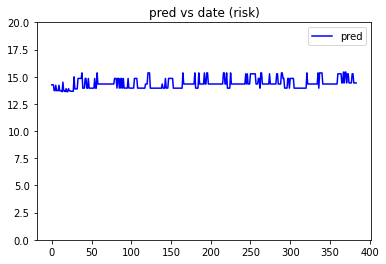

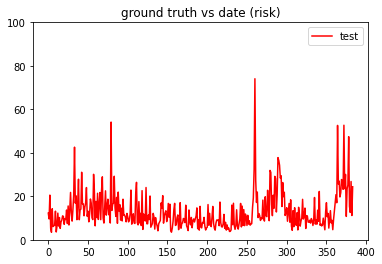

In [40]:
plt.plot(range(len(y_pred_risk.tolist())), y_pred_risk.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (risk)")
plt.ylim([0, 20])
plt.figure()
plt.plot(range(len(y_pred_risk.tolist())), y_test_risk.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (risk)")
plt.ylim([0, 100])

(-2.0, 2.0)

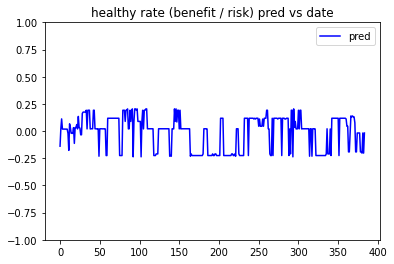

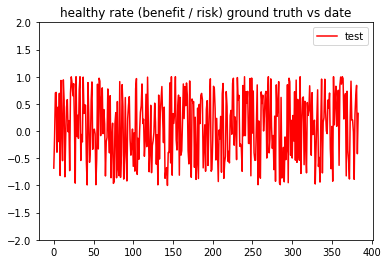

In [41]:
# the larger the health, the better the stock is
plt.plot(range(len(y_pred_benefit.tolist())), y_pred_benefit / y_pred_risk.tolist(), 'b', label='pred')
plt.legend()
plt.title("healthy rate (benefit / risk) pred vs date")
plt.ylim([-1, 1])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target.div(y_test_risk.target), 'r', label='test')
plt.legend()
plt.title("healthy rate (benefit / risk) ground truth vs date")
plt.ylim([-2, 2])

### Inspect data

In [42]:
x_train_benefit, y_train_benefit, x_test_benefit, y_test_benefit, x_valid_benefit, y_valid_benefit = benefit_datasets
x_train_risk, y_train_risk, x_test_risk, y_test_risk, x_valid_risk, y_valid_risk = risk_datasets

In [43]:
benefit_dist = {}
for i in range(-19, 21):
    benefit_dist[((i - 1) * 5, i * 5)] = 0

risk_dist = {}
for i in range(1, 21):
    risk_dist[((i - 1) * 5, i * 5)] = 0

In [45]:
for i in range(y_train_benefit.target.size):
    num = y_train_benefit.target[i]
    num = int(num)
    benefit_dist[(num // 5 * 5, (num // 5 + 1) * 5)] += 1
print(benefit_dist)
print()
for i in range(y_train_risk.target.size):
    num = y_train_risk.target[i]
    num = int(num)
    risk_dist[(num // 5 * 5, (num // 5 + 1) * 5)] += 1
print(risk_dist)

{(-100, -95): 0, (-95, -90): 0, (-90, -85): 0, (-85, -80): 0, (-80, -75): 2, (-75, -70): 4, (-70, -65): 4, (-65, -60): 2, (-60, -55): 6, (-55, -50): 8, (-50, -45): 6, (-45, -40): 22, (-40, -35): 24, (-35, -30): 20, (-30, -25): 30, (-25, -20): 70, (-20, -15): 104, (-15, -10): 190, (-10, -5): 408, (-5, 0): 932, (0, 5): 1440, (5, 10): 530, (10, 15): 258, (15, 20): 152, (20, 25): 86, (25, 30): 32, (30, 35): 24, (35, 40): 12, (40, 45): 2, (45, 50): 6, (50, 55): 0, (55, 60): 2, (60, 65): 0, (65, 70): 2, (70, 75): 0, (75, 80): 2, (80, 85): 0, (85, 90): 0, (90, 95): 0, (95, 100): 0}

{(0, 5): 444, (5, 10): 1654, (10, 15): 954, (15, 20): 514, (20, 25): 306, (25, 30): 172, (30, 35): 104, (35, 40): 68, (40, 45): 44, (45, 50): 24, (50, 55): 32, (55, 60): 12, (60, 65): 20, (65, 70): 8, (70, 75): 4, (75, 80): 12, (80, 85): 0, (85, 90): 4, (90, 95): 4, (95, 100): 0}


Text(0.5, 1.0, 'risk data distribution')

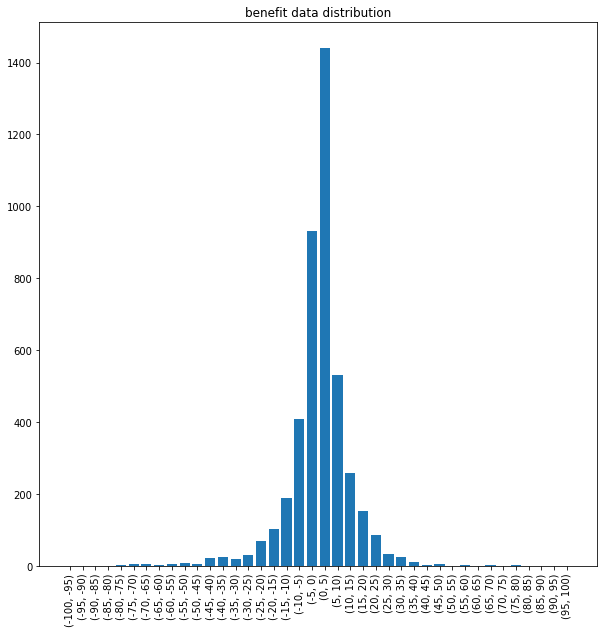

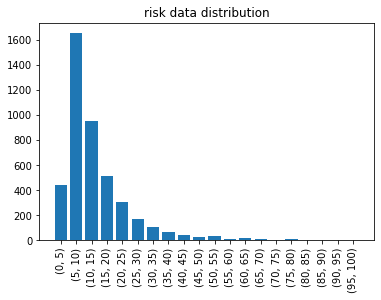

In [46]:
plt.figure(figsize=(10, 10))
plt.bar(list(map(str, benefit_dist.keys())), benefit_dist.values())
plt.xticks(rotation = 90)
plt.title("benefit data distribution")
plt.figure()
plt.bar(list(map(str, risk_dist.keys())), risk_dist.values())
plt.xticks(rotation = 90)
plt.title("risk data distribution")

### Train LSTM

#### Benefit LSTM

In [2]:
provider_uri = "./dataset/dataset_benefit3_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

[23604:MainThread](2022-07-04 13:32:54,841) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[23604:MainThread](2022-07-04 13:32:54,848) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[23604:MainThread](2022-07-04 13:32:54,849) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_benefit3_bin')}
[23604:MainThread](2022-07-04 13:32:55,026) INFO - qlib.timer - [log.py:113] - Time cost: 0.006s | Loading data Done
[23604:MainThread](2022-07-04 13:32:55,028) INFO - qlib.timer - [log.py:113] - Time cost: 0.001s | Fillna Done
[23604:MainThread](2022-07-04 13:32:55,029) INFO - qlib.timer - [log.py:113] - Time cost: 0.002s | fit & process data Done
[23604:MainThread](2022-07-04 13:32:55,030) INFO - qlib.timer - [log.py:113] - Time cost: 0.010s | Init data Done


In [3]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

benefit_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [4]:
benefit_train_dataset = SequenceDataset(ds.prepare('train'), 'target', ['open', 'close', 'high', 'low'])
benefit_train_loader = DataLoader(benefit_train_dataset, batch_size=1, shuffle=True)

benefit_test_dataset = SequenceDataset(ds.prepare('test'), 'target', ['open', 'close', 'high', 'low'])
benefit_test_loader = DataLoader(benefit_test_dataset, batch_size=1, shuffle=True)

benefit_valid_dataset = SequenceDataset(ds.prepare('valid'), 'target', ['open', 'close', 'high', 'low'])
benefit_valid_loader = DataLoader(benefit_valid_dataset, batch_size=1, shuffle=True)

In [26]:
learning_rate = 1e-3
num_hidden_units = 10

model = ShallowRegressionLSTM(num_sensors=4, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [27]:
print("Untrained test\n--------")
test_model(benefit_valid_loader, model, loss_function)
print()

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(benefit_train_loader, model, loss_function, optimizer=optimizer)
    test_model(benefit_valid_loader, model, loss_function)
    print()

Untrained test
--------
tensor([-2.2426]) tensor([0.1686])
tensor([-8.6427]) tensor([0.1654])
tensor([-7.2304]) tensor([0.1628])
tensor([-5.9525]) tensor([0.1686])
tensor([1.5568]) tensor([0.1682])
tensor([1.3493]) tensor([0.1663])
tensor([17.4543]) tensor([0.1698])
tensor([3.1136]) tensor([0.1604])
tensor([2.0085]) tensor([0.1717])
tensor([4.2166]) tensor([0.1696])
tensor([2.4583]) tensor([0.1700])
tensor([-0.4131]) tensor([0.1665])
tensor([8.3334]) tensor([0.1699])
tensor([1.0786]) tensor([0.1613])
tensor([-15.5537]) tensor([0.1602])
tensor([1.3777]) tensor([0.1674])
tensor([0.9890]) tensor([0.1644])
tensor([-2.6578]) tensor([0.1706])
tensor([9.3021]) tensor([0.1693])
tensor([-4.3366]) tensor([0.1622])
tensor([-15.0307]) tensor([0.1589])
tensor([3.2519]) tensor([0.1671])
tensor([4.0293]) tensor([0.1722])
tensor([17.7963]) tensor([0.1612])
tensor([-9.2166]) tensor([0.1704])
tensor([-5.8100]) tensor([0.1669])
tensor([3.9093]) tensor([0.1663])
tensor([7.5275]) tensor([0.1676])
tensor([3

In [28]:
lstm_benefit = model

In [55]:
y_pred_benefit = predict(benefit_test_loader, model)

In [56]:
print(y_pred_benefit)

tensor([-1.7357, -1.9796, -2.0611, -2.0557, -2.0220, -1.9991, -1.8502, -1.8837,
        -2.2088, -1.9805, -2.3054, -2.0048, -2.0445, -2.0123, -2.1508, -1.6149,
        -1.9811, -1.8880, -2.0236, -1.8169, -1.8844, -1.6791, -1.8980, -1.8948,
        -1.7939, -1.7906, -1.3544, -1.8251, -1.9175, -1.9235, -1.8341, -1.8355,
        -1.7755, -2.3328, -2.5571, -2.0056, -1.8955, -2.2713, -1.6753, -2.6462,
        -1.8806, -2.1523, -1.8417, -1.8979, -1.9119, -2.0051, -1.8825, -1.5804,
        -1.9517, -1.8789, -1.8718, -1.6282, -1.8774, -2.0358, -1.9753, -1.9437,
        -1.9775, -2.0151, -1.9825, -1.9818, -1.6975, -1.9323, -1.9080, -2.1417,
        -1.9210, -1.8485, -1.8989, -1.3508, -1.9662, -1.8925, -1.7755, -1.7864,
        -1.8969, -1.9252, -1.9112, -1.8414, -1.8837, -1.9821, -1.8557, -1.6671,
        -1.7694, -1.8096, -1.7386, -1.9271, -1.9193, -2.0516, -1.7934, -1.7831,
        -1.9026, -2.0395, -2.0090, -2.0520, -1.3839, -1.8157, -1.8043, -1.7997,
        -1.7694, -1.9290, -2.1498, -1.84

#### Risk LSTM

In [29]:
provider_uri = "./dataset/dataset_risk3_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

[30236:MainThread](2022-07-01 18:42:18,845) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[30236:MainThread](2022-07-01 18:42:18,851) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[30236:MainThread](2022-07-01 18:42:18,852) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_risk3_bin')}
[30236:MainThread](2022-07-01 18:42:18,940) INFO - qlib.timer - [log.py:113] - Time cost: 0.011s | Loading data Done
[30236:MainThread](2022-07-01 18:42:18,942) INFO - qlib.timer - [log.py:113] - Time cost: 0.000s | Fillna Done
[30236:MainThread](2022-07-01 18:42:18,943) INFO - qlib.timer - [log.py:113] - Time cost: 0.002s | fit & process data Done
[30236:MainThread](2022-07-01 18:42:18,944) INFO - qlib.timer - [log.py:113] - Time cost: 0.015s | Init data Done


In [30]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

risk_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [31]:
risk_train_dataset = SequenceDataset(ds.prepare('train'), 'target', ['open', 'close', 'high', 'low'])
risk_train_loader = DataLoader(risk_train_dataset, batch_size=1, shuffle=True)

risk_test_dataset = SequenceDataset(ds.prepare('test'), 'target', ['open', 'close', 'high', 'low'])
risk_test_loader = DataLoader(risk_test_dataset, batch_size=1, shuffle=True)

risk_valid_dataset = SequenceDataset(ds.prepare('valid'), 'target', ['open', 'close', 'high', 'low'])
risk_valid_loader = DataLoader(risk_valid_dataset, batch_size=1, shuffle=True)

In [32]:
learning_rate = 1e-2
num_hidden_units = 10

model = ShallowRegressionLSTM(num_sensors=4, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [33]:
print("Untrained test\n--------")
test_model(risk_valid_loader, model, loss_function)
print()

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(risk_train_loader, model, loss_function, optimizer=optimizer)
    test_model(risk_valid_loader, model, loss_function)
    print()

Untrained test
--------
tensor([16.7421]) tensor([0.0516])
tensor([6.6789]) tensor([0.0518])
tensor([4.2837]) tensor([0.0504])
tensor([5.9687]) tensor([0.0501])
tensor([9.3530]) tensor([0.0518])
tensor([9.9838]) tensor([0.0514])
tensor([9.2125]) tensor([0.0504])
tensor([4.4506]) tensor([0.0517])
tensor([14.8252]) tensor([0.0515])
tensor([6.6850]) tensor([0.0515])
tensor([7.9997]) tensor([0.0504])
tensor([9.6012]) tensor([0.0515])
tensor([11.2536]) tensor([0.0521])
tensor([5.3846]) tensor([0.0501])
tensor([6.6057]) tensor([0.0512])
tensor([5.0652]) tensor([0.0518])
tensor([4.2858]) tensor([0.0519])
tensor([19.0620]) tensor([0.0519])
tensor([4.9024]) tensor([0.0502])
tensor([3.2113]) tensor([0.0516])
tensor([9.9167]) tensor([0.0480])
tensor([7.6883]) tensor([0.0493])
tensor([7.3790]) tensor([0.0520])
tensor([9.9818]) tensor([0.0497])
tensor([22.8838]) tensor([0.0496])
tensor([11.5854]) tensor([0.0499])
tensor([7.2691]) tensor([0.0515])
tensor([33.0549]) tensor([0.0517])
tensor([17.9286])

In [34]:
lstm_risk = model

In [62]:
y_pred_risk = predict(risk_test_loader, model)
print(y_pred_risk)

tensor([27.8638, 35.7813, 25.9519, 16.1453, 26.7024, 27.3725, 26.6594, 24.5936,
        24.5685, 26.5807, 28.9243, 28.2282, 25.2686, 31.1207, 26.4569, 25.7540,
        26.3399, 27.4181, 25.6765, 25.6244, 30.9274, 25.3052, 25.1671, 28.0666,
        23.1020, 30.0954, 29.7382, 30.3519, 26.4707, 22.4473, 28.1213, 25.4426,
        22.0031, 24.4955, 26.7076, 22.6354, 25.6475, 24.1787, 27.7618, 22.5771,
        21.5754, 26.7644, 30.8385, 33.0377, 26.0132, 30.8377, 24.5550, 31.0291,
        26.6541, 14.5514, 30.3286, 22.9038, 22.5215, 25.4491, 26.8752, 25.1694,
        28.4576, 31.7056, 30.8985, 26.2267, 26.0814, 28.0638, 16.4006, 30.3801,
        26.2318, 35.7613, 26.2038, 12.5230, 30.6805, 28.9189, 13.1031, 27.4698,
        36.8838, 28.7894, 27.9191, 22.5139, 29.7711, 28.0448, 14.7727, 28.3674,
        26.2667, 25.9932, 25.5089, 23.6990, 30.4231, 28.0586, 29.0064, 14.5232,
        35.9792, 19.1603, 30.6027, 29.1514, 25.9229, 23.6510, 15.0770, 13.6208,
        25.5617, 25.7239, 23.3327, 26.35

#### Draw graph

In [63]:
x_train_benefit, y_train_benefit, x_test_benefit, y_test_benefit, x_valid_benefit, y_valid_benefit = benefit_datasets
x_train_risk, y_train_risk, x_test_risk, y_test_risk, x_valid_risk, y_valid_risk = risk_datasets

(-100.0, 100.0)

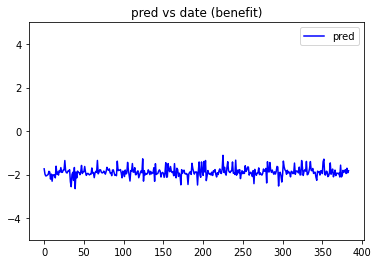

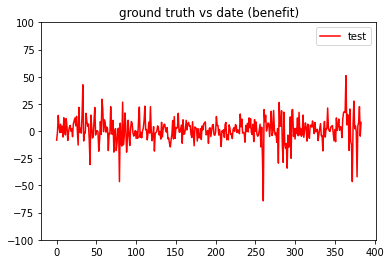

In [64]:
plt.plot(range(len(y_pred_benefit.tolist())), y_pred_benefit.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (benefit)")
plt.ylim([-5, 5])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (benefit)")
plt.ylim([-100, 100])

(0.0, 100.0)

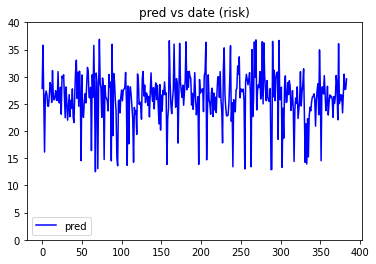

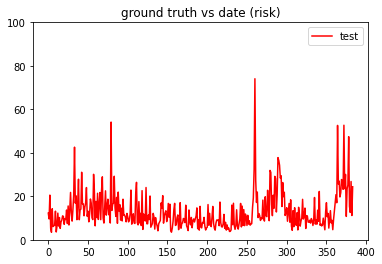

In [67]:
plt.plot(range(len(y_pred_risk.tolist())), y_pred_risk.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (risk)")
plt.ylim([0, 40])
plt.figure()
plt.plot(range(len(y_pred_risk.tolist())), y_test_risk.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (risk)")
plt.ylim([0, 100])

(-2.0, 2.0)

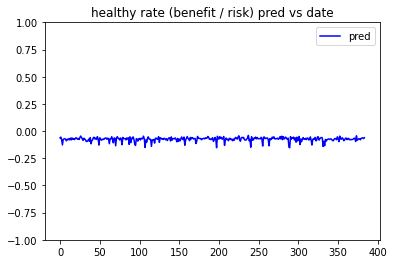

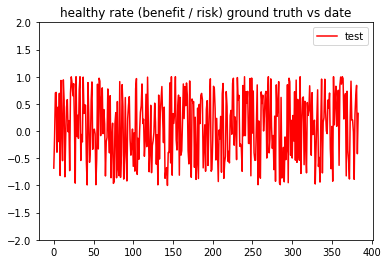

In [68]:
# the larger the health, the better the stock is
plt.plot(range(len(y_pred_benefit.tolist())), (y_pred_benefit / y_pred_risk).tolist(), 'b', label='pred')
plt.legend()
plt.title("healthy rate (benefit / risk) pred vs date")
plt.ylim([-1, 1])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target.div(y_test_risk.target), 'r', label='test')
plt.legend()
plt.title("healthy rate (benefit / risk) ground truth vs date")
plt.ylim([-2, 2])

### benchmark

In [37]:
print(gbm_risk)
print(gbm_benefit)
print(lstm_risk)
print(lstm_benefit)

ShallowRegressionLSTM(
  (lstm): LSTM(4, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)
ShallowRegressionLSTM(
  (lstm): LSTM(4, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)


In [38]:
gbm_benefit.save_model('model/gbm_benefit.txt')
gbm_risk.save_model('model/gbm_risk.txt')

In [40]:
torch.save(lstm_benefit.state_dict(), 'model/lstm_benefit.pkl')
torch.save(lstm_risk.state_dict(), 'model/lstm_risk.pkl')

In [44]:
gbm_benefit = lgb.Booster(model_file='model/gbm_benefit.txt')
gbm_risk = lgb.Booster(model_file='model/gbm_risk.txt')

In [2]:
num_hidden_units = 10

lstm_benefit = ShallowRegressionLSTM(num_sensors=4, hidden_units=num_hidden_units)
lstm_benefit.load_state_dict(torch.load('model/lstm_benefit.pkl'))
lstm_benefit.eval()

lstm_risk = ShallowRegressionLSTM(num_sensors=4, hidden_units=num_hidden_units)
lstm_risk.load_state_dict(torch.load('model/lstm_risk.pkl'))
lstm_risk.eval()

ShallowRegressionLSTM(
  (lstm): LSTM(4, 10, num_layers=2, batch_first=True)
  (linear): Linear(in_features=10, out_features=1, bias=True)
)

In [3]:
qlib.init(provider_uri="dataset/selected_csi300_bin/")

[29016:MainThread](2022-07-04 14:23:04,159) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[29016:MainThread](2022-07-04 14:23:04,165) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[29016:MainThread](2022-07-04 14:23:04,166) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/selected_csi300_bin')}


In [4]:
qdl = QlibDataLoader(config=[['$open59', '$close59', '$high59', '$low59', '$benefit', '$risk'], ['open', 'close', 'high', 'low', 'benefit', 'risk']])
df = qdl.load(start_time='2019-08-01', end_time='2020-07-31')

c:\Users\v-junmzhang\Anaconda3\envs\qlib\lib\site-packages\qlib\data\dataset\loader.py:203: UserWarning: `instruments` is not set, will load all stocks
  warnings.warn("`instruments` is not set, will load all stocks")


In [5]:
df

open     close      high       low    benefit  \
datetime   instrument                                                      
2019-08-01 SH600372    0.979223  0.994723  1.014941  0.977201  -0.131458   
           SH600705    1.021526  1.025440  1.041096  1.021526  -0.051621   
           SH601933    0.985435  0.986484  1.012720  0.977039   0.166656   
           SZ000063    0.871983  0.864650  0.897036  0.860984  -0.018052   
           SZ000625    1.004144  0.986121  1.015730  0.983546  -0.379923   
...                         ...       ...       ...       ...        ...   
2020-07-31 SZ000625    0.950271  0.952080  0.965642  0.937613  10.033978   
           SZ000728    0.774178  0.769457  0.782675  0.768513 -64.885735   
           SZ000776    0.877081  0.873240  0.880282  0.872599 -30.089331   
           SZ002142    0.887133  0.874222  0.887133  0.867766  -6.023204   
           SZ002371    0.771978  0.759273  0.788040  0.752752 -40.825333   

                            risk  
datetime   instrument             
2019-08-01 SH600372     0.106758  
           SH600705     0.125869  
           SH601933     0.100355  
           SZ000063     0.119644  
           SZ000625     0.144307  
...                          ...  
2020-07-31 SZ000625    10.424892  
           SZ000728     7.041414  
           SZ000776     6.304430  
           SZ002142     7.035649  
           SZ002371    11.390723  

[1977 rows x 6 columns]

In [6]:
df[['open', 'close', 'high', 'low']]

open     close      high       low
datetime   instrument                                        
2019-08-01 SH600372    0.979223  0.994723  1.014941  0.977201
           SH600705    1.021526  1.025440  1.041096  1.021526
           SH601933    0.985435  0.986484  1.012720  0.977039
           SZ000063    0.871983  0.864650  0.897036  0.860984
           SZ000625    1.004144  0.986121  1.015730  0.983546
...                         ...       ...       ...       ...
2020-07-31 SZ000625    0.950271  0.952080  0.965642  0.937613
           SZ000728    0.774178  0.769457  0.782675  0.768513
           SZ000776    0.877081  0.873240  0.880282  0.872599
           SZ002142    0.887133  0.874222  0.887133  0.867766
           SZ002371    0.771978  0.759273  0.788040  0.752752

[1977 rows x 4 columns]

In [58]:
gbm_benefit.predict(df[['open', 'close', 'high', 'low']], num_iteration=gbm.best_iteration)

array([-0.18237212, -0.18237212, -0.18237212, ..., -0.18237212,
       -0.18237212, -0.18237212])

In [59]:
gbm_risk.predict(df[['open', 'close', 'high', 'low']], num_iteration=gbm.best_iteration)

array([13.98821301, 13.98821301, 13.98821301, ..., 13.98821301,
       13.98821301, 13.98821301])

In [7]:
benefit_dataset = SequenceDataset(df[['open', 'close', 'high', 'low', 'benefit']], 'benefit', ['open', 'close', 'high', 'low'])
benefit_loader = DataLoader(benefit_dataset, batch_size=1, shuffle=True)

In [8]:
predict(benefit_loader, lstm_benefit)

tensor([0.6176, 0.5600, 0.6814,  ..., 0.5695, 0.6203, 0.6509])

In [9]:
risk_dataset = SequenceDataset(df[['open', 'close', 'high', 'low', 'risk']], 'risk', ['open', 'close', 'high', 'low'])
risk_loader = DataLoader(risk_dataset, batch_size=1, shuffle=True)

In [11]:
y = predict(risk_loader, lstm_risk)